In [1]:
!pip install split-folders
!pip install skorch 
!pip install torchsummary

     |████████████████████████████████| 155 kB 4.3 MB/s            


In [2]:
import os
import warnings
import torchvision
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import splitfolders

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchsummary import summary
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.helper import predefined_split

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
print(torch.__version__)

1.9.1


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
data_dir = '../input/brain-tumor-classification-mri'
classes = os.listdir(data_dir + "/Training")

print('Classes:')
for idx, train_class in enumerate(classes):
    print(f'{idx+1}. {train_class}')

Classes:
1. no_tumor
2. pituitary_tumor
3. meningioma_tumor
4. glioma_tumor


In [6]:
size_traning = 0

print('Datasets traning size:')
for idx,train_class in enumerate(classes):
  size  = len(os.listdir(data_dir + f"/Training/{train_class}"))
  size_traning += size
  print(f'{idx+1}. {train_class} {size}')
print(f'Sum {size_traning}')

Datasets traning size:
1. no_tumor 395
2. pituitary_tumor 827
3. meningioma_tumor 822
4. glioma_tumor 826
Sum 2870


In [7]:
size_testing = 0

print('Datasets testing size:')
for idx,test_class in enumerate(classes):
  size  = len(os.listdir(data_dir + f"/Testing/{test_class}"))
  size_testing += size
  print(f'{idx+1}. {test_class} {size}')
print(f'Sum {size_testing}')

Datasets testing size:
1. no_tumor 105
2. pituitary_tumor 74
3. meningioma_tumor 115
4. glioma_tumor 100
Sum 394


In [8]:
splitfolders.ratio(data_dir+ "/Training", output='brain-tumor-classification-mri', ratio=(0.9008,0.0992))

Copying files: 2870 files [00:14, 201.21 files/s]


In [9]:
image_size = (224,224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])


dataset_training = ImageFolder('./brain-tumor-classification-mri/train', transform=transform)
dataset_validating = ImageFolder('./brain-tumor-classification-mri/val', transform=transform)
dataset_testing = ImageFolder(data_dir+'/Testing', transform=transform)
print(f'Size train {len(dataset_training)}') 
print(f'Size valid {len(dataset_validating)}')
print(f'Size test {len(dataset_testing)}') 

Size train 2583
Size valid 287
Size test 394


In [10]:
img, label = dataset_training[19]
print(f'Input shape: {img.shape}')
print(img)
print(torch.max(img), torch.min(img))

Input shape: torch.Size([3, 224, 224])
tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.9765, -0.9765, -0.9765],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.9765, -0.9765, -0.9765],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
      

In [11]:
batch_size=32
train_loader = DataLoader(dataset_training ,batch_size=batch_size,shuffle=True)
val_loader =  DataLoader(dataset_validating ,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(dataset_testing,batch_size=batch_size,shuffle=False)

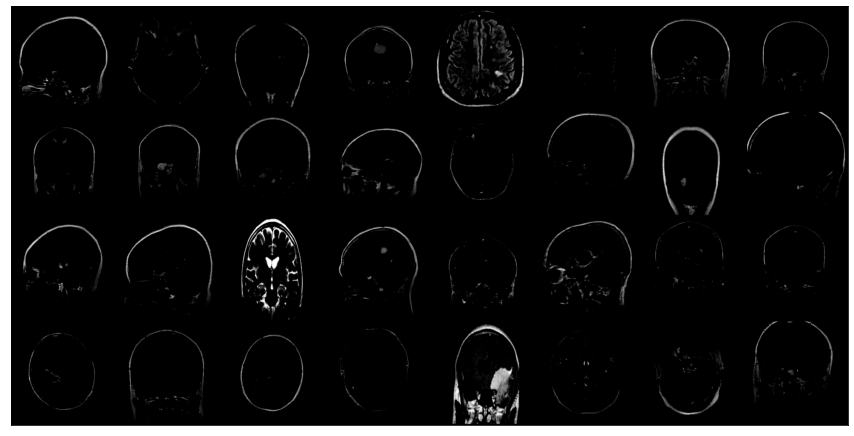

In [12]:
examples = iter(train_loader)
img,labels = examples.next()
def show_batch(dataset_loader):
    _, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img).permute(1, 2, 0))
show_batch(train_loader)

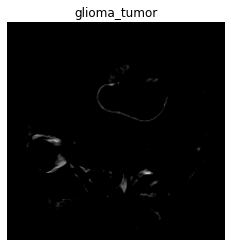

In [13]:
def show_image(img, label):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'{dataset_training.classes[label]}')
    plt.axis("off")
    plt.show()

show_image(*dataset_training[11])

In [14]:
y_test = np.array([y for x, y in iter(dataset_testing)])

In [15]:
def display_report_and_matrix(y_pred, model):
    print(f'Test {model} Pytorch and Skorch')
    y_prediction = np.argmax(y_pred, axis=1)
    report = classification_report(y_test, y_prediction, target_names=dataset_training.classes)
    print(f'{report}')
    
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax.set_title(f'Confusion Matrix {model} Pytorch and Skorch')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dataset_training.classes)
    disp.plot(cmap='Blues', ax=ax)

In [16]:
def display_plot(history, model):
    plt.figure(figsize=(14, 8))
    tab_plot = [{
                "id": 1,
                "variables":['train_acc', 'valid_acc'],
                "labels":['Training Accuracy', 'Validation Accuracy'],
                "legend":'lower right',
                "title":f'Accuracy Pytorch and Skorch - {model}',
                "ylabel":'Accuracy'
            },{ 
                "id": 2,
                "variables":['train_loss', 'valid_loss'],
                "labels":['Training Loss', 'Validation Loss'],
                "legend":'upper right',
                "title":f'Loss Pytorch and Skorch - {model}',
                "ylabel":'Loss'
            }]
    
    for tab in tab_plot: 
        plt.subplot(1, 2, tab['id'])
        plt.plot(history[:, tab['variables'][0]], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
        plt.plot(history[:, tab['variables'][1]], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
        plt.legend(loc=tab['legend'])
        plt.title(tab['title'])
        plt.xlabel('Epochs')
        plt.ylabel(tab['ylabel'])
    plt.show()

In [17]:
train_acc = EpochScoring(scoring='accuracy', on_train=True, 
                         name='train_acc', lower_is_better=False)
callbacks = [train_acc]

In [22]:
class ModelMmobilenetV2(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(1280, output_features)
        self.model = model

      def forward(self, x):
        return self.model(x)
        
net_mobilenetv2 = NeuralNetClassifier(
    ModelMmobilenetV2,
    module__output_features=4,
    max_epochs=25,
    lr=0.001,
    batch_size=32,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [23]:
warnings.filterwarnings('ignore')
print('Train Mobilenetv2 Pytorch and Skorch')
net_mobilenetv2.fit(dataset_training, y=None)

Train Mobilenetv2 Pytorch and Skorch
  epoch    train_acc    train_loss    valid_acc    valid_loss      dur
-------  -----------  ------------  -----------  ------------  -------
      1       0.8343        0.4217       0.9338        0.2063  22.2874
      2       0.9264        0.2192       0.9582        0.1348  22.7871
      3       0.9632        0.1174       0.9373        0.1571  22.7573
      4       0.9597        0.1250       0.9443        0.1541  22.2279
      5       0.9652        0.1215       0.9477        0.1648  22.3856
      6       0.9748        0.0716       0.9164        0.3238  22.4518
      7       0.9683        0.0937       0.9686        0.0958  22.1582
      8       0.9923        0.0329       0.9721        0.0648  22.6268
      9       0.9876        0.0362       0.9024        0.3317  22.7132
     10       0.9799        0.0589       0.9582        0.1300  22.1987
     11       0.9733        0.0795       0.9617        0.1558  22.6568
     12       0.9760        0.0636      

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ModelMmobilenetV2(
    (model): MobileNetV2(
      (features): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
     

Test Mobilenetv2 Pytorch and Skorch
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.21      0.34       100
meningioma_tumor       0.82      0.97      0.89       115
        no_tumor       0.60      1.00      0.75       105
 pituitary_tumor       0.95      0.78      0.86        74

        accuracy                           0.75       394
       macro avg       0.83      0.74      0.71       394
    weighted avg       0.82      0.75      0.71       394



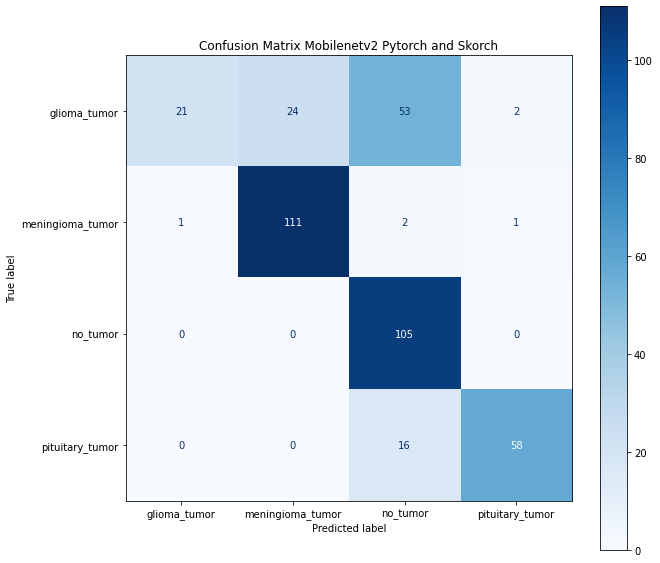

In [24]:
y_pred_mobilenetv2 = net_mobilenetv2.predict_proba(dataset_testing) 
display_report_and_matrix(y_pred_mobilenetv2,'Mobilenetv2')

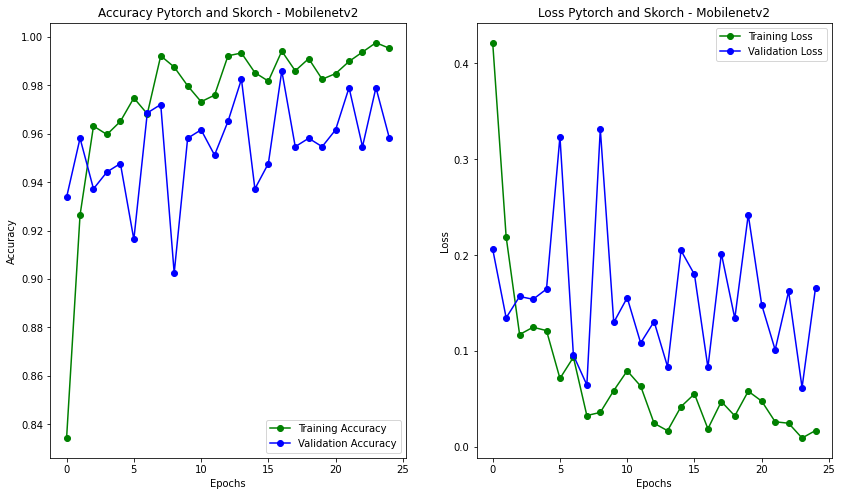

In [25]:
display_plot(net_mobilenetv2.history, 'Mobilenetv2')

In [26]:
class ModelDenseNet121(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(1024, output_features)
        self.model = model

      def forward(self, x):
        return self.model(x)
       
net_densenet121 =  NeuralNetClassifier(
    ModelDenseNet121,
    module__output_features=4,
    max_epochs=25,
    lr=0.001,
    batch_size=32,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [27]:
warnings.filterwarnings('ignore')
print('Train DenseNet121 Pytorch and Skorch')
net_densenet121.fit(dataset_training, y=None)

Train DenseNet121 Pytorch and Skorch


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss      dur
-------  -----------  ------------  -----------  ------------  -------
      1       0.8444        0.4241       0.7526        0.7474  32.5154
      2       0.9148        0.2352       0.9268        0.2099  32.6115
      3       0.9473        0.1585       0.8990        0.3008  32.7735
      4       0.9613        0.1029       0.9686        0.1323  32.5146
      5       0.9570        0.1248       0.9268        0.1804  32.7221
      6       0.9702        0.0894       0.9338        0.1691  32.5353
      7       0.9717        0.0836       0.9094        0.2399  32.3660
      8       0.9748        0.0746       0.9617        0.1103  32.3914
      9       0.9884        0.0390       0.8990        0.3023  32.3048
     10       0.9810        0.0505       0.9129        0.2925  32.3956
     11       0.9849        0.0448       0.9582        0.2269  32.5303
     12       0.9892        0.0366       0.9129        0.3175  32.3273
     1

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ModelDenseNet121(
    (model): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

Test DenseNet121 Pytorch and Skorch
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.26      0.41       100
meningioma_tumor       0.60      1.00      0.75       115
        no_tumor       0.77      1.00      0.87       105
 pituitary_tumor       0.97      0.50      0.66        74

        accuracy                           0.72       394
       macro avg       0.83      0.69      0.67       394
    weighted avg       0.81      0.72      0.68       394



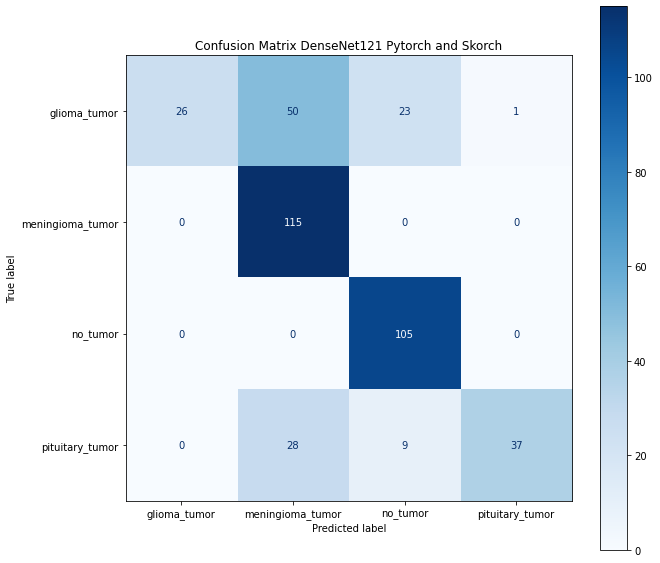

In [28]:
y_pred_densenet121 = net_densenet121.predict_proba(dataset_testing) 
display_report_and_matrix(y_pred_densenet121, 'DenseNet121')

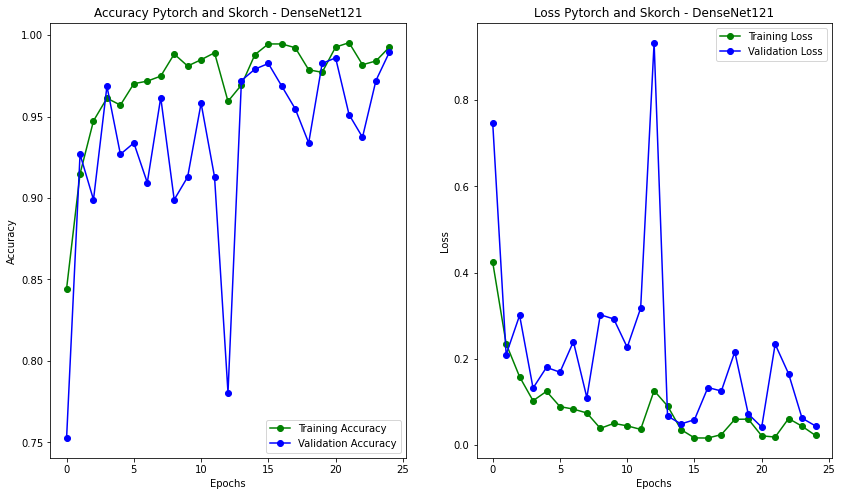

In [29]:
display_plot(net_densenet121.history, 'DenseNet121')

In [39]:
class ModelResnet50(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(2048, output_features)
        self.model = model

      def forward(self, x):
        return self.model(x)

net_resnet50 =  NeuralNetClassifier(
    ModelResnet50,
    module__output_features=4,
    max_epochs=25,
    lr=0.001,
    batch_size=32,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [40]:
warnings.filterwarnings('ignore')
print('Train Resnet50 Pytorch and Skorch')
net_resnet50.fit(dataset_training, y=None)

Train Resnet50 Pytorch and Skorch
  epoch    train_acc    train_loss    valid_acc    valid_loss      dur
-------  -----------  ------------  -----------  ------------  -------
      1       0.7832        0.6158       0.7108        0.9916  29.6462
      2       0.8901        0.3118       0.8571        0.4449  29.6053
      3       0.9230        0.2139       0.9059        0.3035  29.8219
      4       0.9315        0.2011       0.3659        2.1992  29.7882
      5       0.9268        0.1860       0.9059        0.2911  29.8822
      6       0.9617        0.1136       0.8571        0.5230  29.7528
      7       0.9593        0.1227       0.9199        0.2866  29.9289
      8       0.9710        0.0828       0.7596        0.8513  29.4955
      9       0.9624        0.1087       0.7944        0.7158  29.6180
     10       0.9683        0.1047       0.8537        0.8419  29.8611
     11       0.9667        0.1037       0.8955        0.4675  29.7480
     12       0.9791        0.0657       0.

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ModelResnet50(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tra

Test Resnet50 Pytorch and Skorch
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.23      0.37       100
meningioma_tumor       0.77      0.97      0.86       115
        no_tumor       0.70      0.99      0.82       105
 pituitary_tumor       0.89      0.92      0.91        74

        accuracy                           0.78       394
       macro avg       0.84      0.78      0.74       394
    weighted avg       0.83      0.78      0.73       394



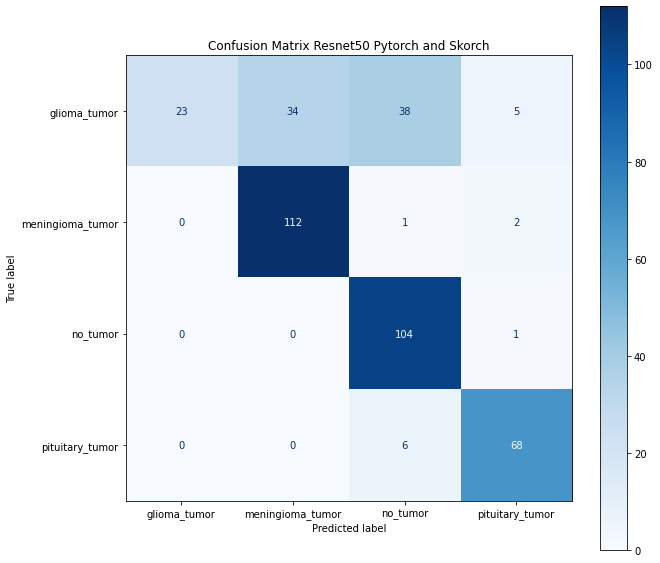

In [41]:
y_pred_resnet50 = net_resnet50.predict_proba(dataset_testing) 
display_report_and_matrix(y_pred_resnet50, 'Resnet50')

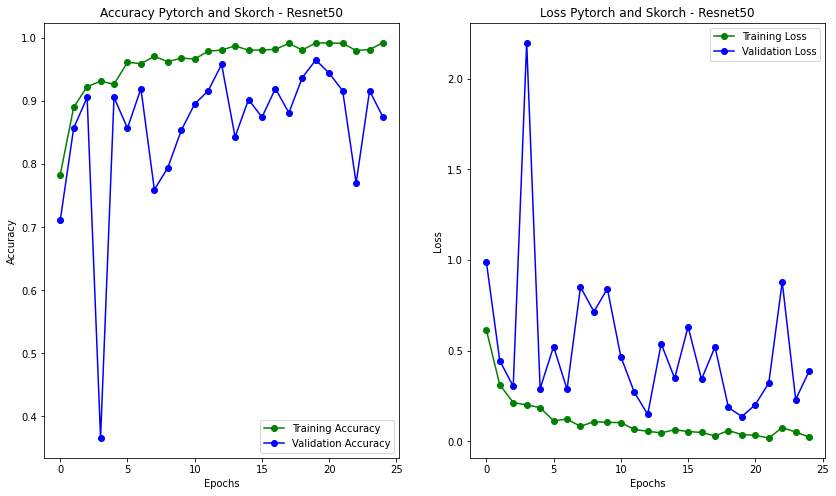

In [42]:
display_plot(net_resnet50.history, 'Resnet50')